# MNIST classification example with TensorFlow
1- MNIST dataset in memory  
2- Feed data using tf.data.dataset API  
3- Model using tf.keras API  
4- Local training and testing using tf.keras API  
5- Use TensorBoard to monitor training  
6- Monitor loss and accuracy
7- Save the model

## Install packages on Google  Cloud Datalab (locally use conda env)

### Select in the Python3 Kernel:
In the menu bar the of 'Kernel', select   
**python3**
### Install needed packages
copy the command below in a Google Cloud Datalab cell  
**!pip install tensorflow==1.12**
### Restart the Kernel 
this is to take into account the new installed packages. Click in the menu bar on:  
**Reset Session**

## Include paths to our functions

In [17]:
import sys
import os
import pathlib

workingdir=os.getcwd()
print(workingdir)
d=[d for d in os.listdir(workingdir)]
n=0
while not set(['notebook']).issubset(set(d)):
   workingdir=str(pathlib.Path(workingdir).parents[0])
   print(workingdir)
   d=[d for d in os.listdir(str(workingdir))]
   n+=1
   if n>5:
       break
sys.path.insert(0, workingdir)
os.chdir(workingdir)

/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP/notebook
/Users/tarrade/Desktop/Work/Data_Science/Tutorials_Codes/Python/proj_DL_models_and_pipelines_with_GCP


## Needed librairies

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
#import gzip
import sys
#import _pickle as cPickle
import shutil
import glob
import re
import os
import codecs
import json 
import subprocess
import requests
import google.auth
import pickle

In [2]:
print(tf.__version__)
print(tf.keras.__version__)

1.12.0
2.1.6-tf


In [35]:
import src.utils.mnist_utils as mnist_utils

In [36]:
import importlib
importlib.reload(mnist_utils); # to reload the function and mask the output

## Input Data
### Load the data

In [37]:
# load the data: path is relative to the python path!
(x_train, y_train), (x_test, y_test) = mnist_utils.load_data(path='data/mnist/raw/mnist.pkl.gz')

### Basics checks

In [38]:
# check data shape (training)
x_train.shape

(60000, 28, 28)

In [39]:
# check data shape (train)
x_test.shape

(10000, 28, 28)

In [40]:
x_train.dtype, x_test.dtype

(dtype('uint8'), dtype('uint8'))

In [41]:
np.max(x_train), np.min(x_train), np.max(x_test), np.min(x_test)  

(255, 0, 255, 0)

### Size of the data

In [8]:
x_test.nbytes/1024.0**2

7.476806640625

In [9]:
x_train.nbytes/1024.0**2

44.86083984375

In [10]:
y_test.nbytes/1024.0**2

0.0095367431640625

In [11]:
y_train.nbytes/1024.0**2

0.057220458984375

### Saving the data as pickle files

In [15]:
pickle.dump(x_train, open('../data/mnist/numpy_train/x_train.pkl', 'wb'))
pickle.dump(x_test, open('../data/mnist/numpy_test/x_test.pkl', 'wb'))

In [16]:
pickle.dump(y_train, open('../data/mnist/numpy_train/y_train.pkl', 'wb'))
pickle.dump(y_test, open('../data/mnist/numpy_test/y_test.pkl', 'wb'))

## Visualize the data

### Some example from training dataset

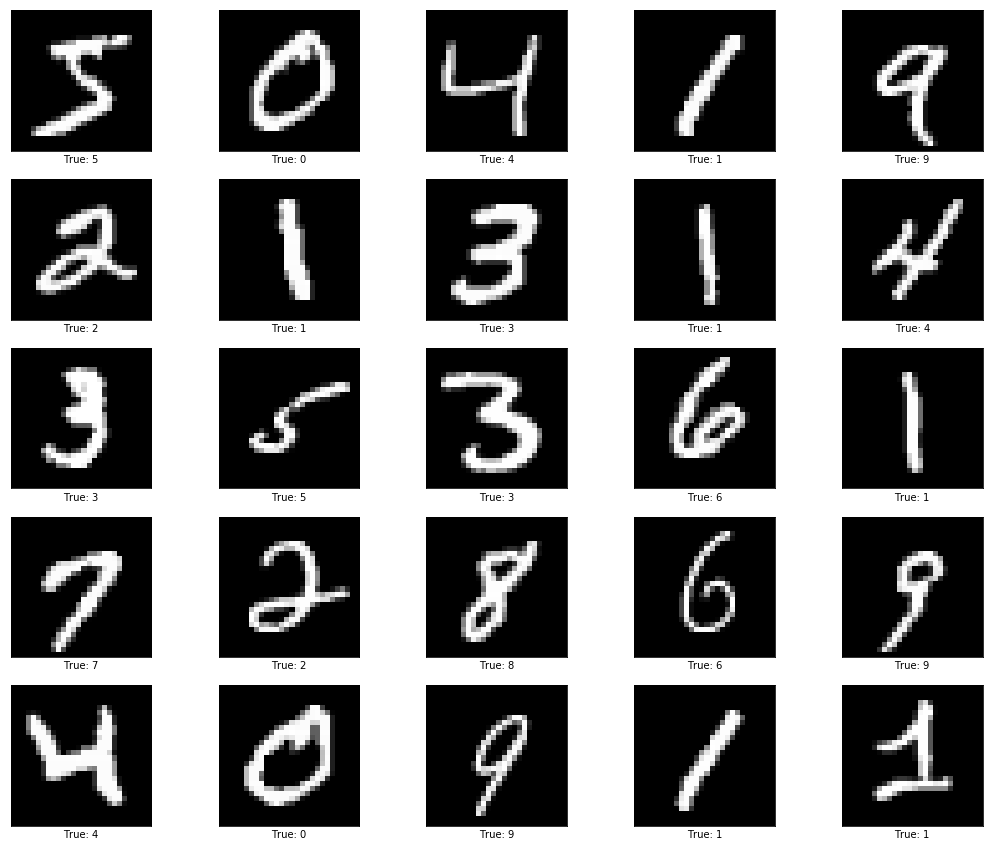

In [19]:
mnist_utils.plot_mnist_images(x_train[0:25], y_train[0:25])

### Some example from testing dataset

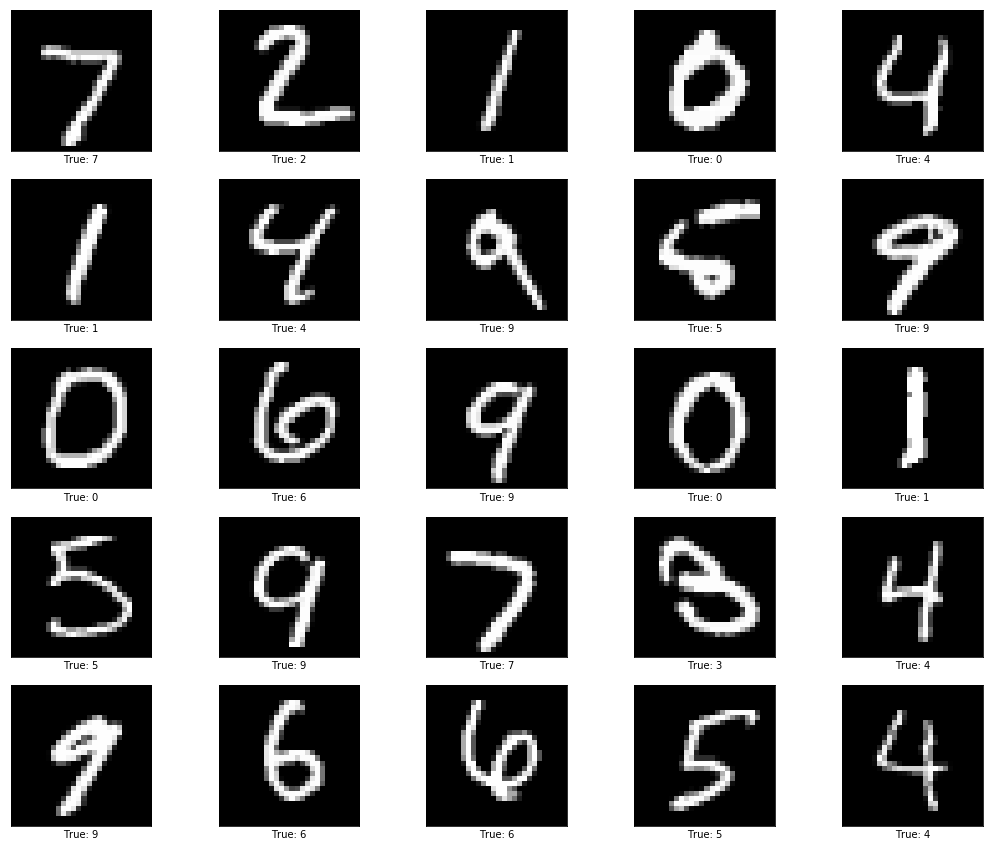

In [21]:
mnist_utils.plot_mnist_images(x_test[0:25], y_test[0:25])

## Defined some hyperparameters

In [3]:
tf.logging.set_verbosity(tf.logging.INFO)

In [21]:
# number of classes
NUM_CLASSES =10

# dimension of the input data
DIM_INPUT = 784

# number of epoch to train our model
EPOCHS = 10

# size of our mini batch
BATCH_SIZE = 128

# shuffle buffer size
SHUFFLE_BUFFER_SIZE = 10 * BATCH_SIZE

# prefetch buffer size
PREFETCH_BUFFER_SIZE = tf.contrib.data.AUTOTUNE

# number of paralell calls
NUM_PARALELL_CALL = 4

## Defined flags

In [22]:
def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()    
    keys_list = [keys for keys in flags_dict]    
    for keys in keys_list:
        FLAGS.__delattr__(keys)
    
del_all_flags(tf.flags.FLAGS)

In [23]:
tf.app.flags.DEFINE_string('f', '', 'kernel') # just for jupyter notebook and avoir : "UnrecognizedFlagError: Unknown command line flag 'f'"
tf.app.flags.DEFINE_string('model_dir_keras', '../results/Models/Mnist/tf_1_12/keras/ckpt/', 'Dir to save a model and checkpoints with keras')
tf.app.flags.DEFINE_string('tensorboard_dir_keras', '../results/Models/Mnist/tf_1_12/keras/logs/', 'Dir to save logs for TensorBoard with keras')
tf.app.flags.DEFINE_integer('shuffle_buffer_size', SHUFFLE_BUFFER_SIZE , 'Shuffle buffer size')
tf.app.flags.DEFINE_integer('prefetch_buffer_size', PREFETCH_BUFFER_SIZE, 'Prefetch buffer size')
tf.app.flags.DEFINE_integer('batch_size', BATCH_SIZE, 'Batch size')
tf.app.flags.DEFINE_integer('epoch', EPOCHS, 'number of epoch')
tf.app.flags.DEFINE_integer('num_parallel_calls', NUM_PARALELL_CALL, 'Number of paralell calls')
FLAGS = tf.app.flags.FLAGS

## Use tf.data.dataset to feed the Keras model

In [24]:
def preprocessing_fn(image, label):
    
    # reshape the images from 28 x 28 to 784
    image = tf.reshape(image, [DIM_INPUT])
    
    # cast images from uint8 to float32
    image = tf.cast(image, tf.float32)
    
    # renormalize images 255 grey variation
    image/= 255
    
    # convert class vectors to binary class matrices
    label = tf.one_hot(label, NUM_CLASSES)
    
    return image, label

In [25]:
def input_dataset_fn(x_data, y_data, batch_size=128, mode=tf.estimator.ModeKeys.TRAIN):
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        tf.logging.info("input_dataset_fn: PREDICT, {}".format(mode))
    elif mode == tf.estimator.ModeKeys.EVAL:
        tf.logging.info("input_dataset_fn: EVAL, {}".format(mode))
    elif mode == tf.estimator.ModeKeys.TRAIN:
        tf.logging.info("input_dataset_fn: TRAIN, {}".format(mode))
    
    # 1) convert the inputs to a Dataset.
    dataset = tf.data.Dataset.from_tensor_slices((x_data, y_data))
    
    # 2) shuffle (with a big enough buffer size)    :        
    if mode == tf.estimator.ModeKeys.TRAIN:
        #num_epochs = None # loop indefinitely
        num_epochs = FLAGS.epoch
        dataset = dataset.shuffle(buffer_size=FLAGS.shuffle_buffer_size, seed=2)# depends on sample size
    else:
        #num_epochs = 1 # end-of-input after this
        num_epochs = FLAGS.epoch
        
    print('the number of epoch: num_epoch =', num_epochs)
    
    # 3) automatically refill the data queue when empty
    dataset = dataset.repeat(num_epochs)
    
    # 4) map
    dataset = dataset.map(preprocessing_fn)#, num_parallel_calls=FLAGS.num_parallel_calls)

    # 5) create batches of data
    dataset = dataset.batch(batch_size=batch_size, drop_remainder=True)
    
    # 6) prefetch data for faster consumption, based on your system and environment, allows the tf.data runtime to automatically tune the prefetch buffer sizes
    dataset = dataset.prefetch(FLAGS.prefetch_buffer_size)

    return dataset

## Machine Learning modelling with Keras
### Build the model

In [26]:
FLAGS.model_dir_keras

'../results/Models/Mnist/tf_1_12/keras/ckpt/'

In [27]:
shutil.rmtree(FLAGS.model_dir_keras, ignore_errors=True)

In [31]:
def baseline_model(opt='tf'):
    # create model
    model = tf.keras.Sequential()
 
    # hidden layer
    model.add(tf.keras.layers.Dense(512, 
                    input_dim=DIM_INPUT,
                    kernel_initializer=tf.keras.initializers.he_normal(),
                    bias_initializer=tf.keras.initializers.Zeros(),
                    activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    
    model.add(tf.keras.layers.Dense(512,  
                    kernel_initializer=tf.keras.initializers.he_normal(),
                    bias_initializer=tf.keras.initializers.Zeros(),
                    activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
        
    # last layer
    model.add(tf.keras.layers.Dense(NUM_CLASSES, 
                    kernel_initializer=tf.keras.initializers.he_normal(),
                    bias_initializer=tf.keras.initializers.Zeros(),
                    activation='softmax'))
    
    # weight initialisation
    # He: keras.initializers.he_normal(seed=None)
    # Xavier: keras.initializers.glorot_uniform(seed=None)
    # Radom Normal: keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
    # Truncated Normal: keras.initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=None)
    
    if opt=='keras':
        optimiser=tf.keras.optimizers.Adam(lr=0.01, beta_1=0.9)
        # GD/SGC:   keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
        # Adam:     keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
        # RMSProp:  keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
        # Momentum: keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.0, nesterov=False)
    else:
        #optimiser (use tf.train and not tf.keras to use MirrorStrategy)
        # https://www.tensorflow.org/api_docs/python/tf/train/Optimizer
        optimiser=tf.train.AdamOptimizer #(learning_rate=0.001, beta1=0.9)
        # GD/SGC:   tf.train.GradientDescentOptimizer(learning_rate, use_locking=False, name='GradientDescent') 
        # Adam:     tf.train.AdamOptimizer(learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-08, use_locking=False,name='Adam')
        # RMSProp:  tf.train.RMSPropOptimizer(learning_rate, decay=0.9, momentum=0.0, epsilon=1e-10, use_locking=False, centered=False, name='RMSProp')
        # Momentum: tf.train.MomentumOptimizer(learning_rate, momentum, use_locking=False, name='Momentum', use_nesterov=False)
    
    # Compile model
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimiser, 
                  metrics=['accuracy'])
    return model

In [32]:
# reset the model
tf.keras.backend.clear_session()

In [33]:
# build the model
# keras optimiser
model_opt_keras = baseline_model(opt='keras')

### Check the nuber of parameters

In [34]:
model_opt_keras.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


### Check input and output layer names

In [83]:
model_opt_keras.input_names # Use this name as the dictionary key in the TF input function

['dense_input']

In [84]:
model_opt_keras.output_names

['dense_2']

## Call back with Keras

### Print info during iterations

In [35]:
class UDFPrint(tf.keras.callbacks.Callback):
    def __init__(self, test_data):
        self.test_data = test_data
        
    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        _, __, x_train, y_train = self.test_data
        loss_train, acc_train = self.model.evaluate(x_train, y_train, verbose=0)
        print('Reached epoch {0:3d} cost J = {1:.5f}'.format(epoch, loss_train))
        return

    def on_epoch_end(self, epoch, logs={}):
        x_test, y_test, x_train, y_train = self.test_data
        loss_train, acc_train = self.model.evaluate(x_train, y_train, verbose=0)
        loss_test, acc_test = self.model.evaluate(x_test, y_test, verbose=0)
        print(' accurary on the training set {0:.4f}'.format(acc_train))
        print(' accurary on the testing set {0:.4f}'.format(acc_test))

    def on_batch_begin(self, batch, logs={}):
        #print('  ---> starting minibatch', batch)
        return

    def on_batch_end(self, batch, logs={}):
        #print('  ---> ending minibatch', batch)
        return
return

### TensorBoard

In [36]:
FLAGS.tensorboard_dir_keras

'../results/Models/Mnist/tf_1_12/keras/logs/'

In [37]:
for file in glob.glob(FLAGS.tensorboard_dir_keras+'*'):
    print(re.findall(r'[^\\/]+|[\\/]',file)[-1])

events.out.tfevents.1549038093.Fabien-Tarrades-MacBook-Pro.local
events.out.tfevents.1550656254.Fabien-Tarrades-MacBook-Pro.local
events.out.tfevents.1549050335.Fabien-Tarrades-MacBook-Pro.local
events.out.tfevents.1549054236.Fabien-Tarrades-MacBook-Pro.local
events.out.tfevents.1550678028.Fabien-Tarrades-MacBook-Pro.local
events.out.tfevents.1549054008.Fabien-Tarrades-MacBook-Pro.local
events.out.tfevents.1550675324.Fabien-Tarrades-MacBook-Pro.local
events.out.tfevents.1550678132.Fabien-Tarrades-MacBook-Pro.local
events.out.tfevents.1549038351.Fabien-Tarrades-MacBook-Pro.local
events.out.tfevents.1550654352.Fabien-Tarrades-MacBook-Pro.local
events.out.tfevents.1550679523.Fabien-Tarrades-MacBook-Pro.local
events.out.tfevents.1549050551.Fabien-Tarrades-MacBook-Pro.local
events.out.tfevents.1550653969.Fabien-Tarrades-MacBook-Pro.local
events.out.tfevents.1550676595.Fabien-Tarrades-MacBook-Pro.local
events.out.tfevents.1550675543.Fabien-Tarrades-MacBook-Pro.local


In [38]:
shutil.rmtree(FLAGS.tensorboard_dir_keras+'*' ,ignore_errors=True)

In [39]:
tbCallBack=tf.keras.callbacks.TensorBoard(log_dir=FLAGS.tensorboard_dir_keras, 
                                          histogram_freq=1, 
                                          write_graph=True)

## Helper functions 

### Define plot style

In [40]:
print(plt.style.available)

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [41]:
plt.style.use('seaborn-ticks')

### Plot for accuracy and loss

In [42]:
def plot_acc_loss(history):
    # plot the training loss and accuracy
    fig = plt.figure(figsize=(9, 3), dpi=100)
    plt.subplots_adjust(wspace = 0.6 )
    ax1 = plt.subplot(121)
    ax2 = plt.subplot(122)
    ax1.plot(np.arange(0, EPOCHS), history.history['acc'], 'b', label='training accuracy')
    ax1.plot(np.arange(0, EPOCHS), history.history['val_acc'], 'r', label='validation accuracy');
    ax1.set_title('Accuracy')
    ax1.set_xlabel("Number of epoch ")
    ax1.set_ylabel("Accuracy")
    ax1.legend(loc="best")


    ax2.plot(np.arange(0, EPOCHS), history.history["loss"], label="training loss")
    ax2.plot(np.arange(0, EPOCHS), history.history["val_loss"], label="validation loss")
    ax2.set_title("Loss")
    ax2.set_xlabel("Number of epoch ")
    ax2.set_ylabel("Loss")
    ax2.legend(loc="best");
    
    print('Loss:')
    print('  - loss [training dataset]: {0:.3f}'.format(history.history['loss'][-1]))
    print('  - loss [validation dataset: {0:.3f}'.format(history.history['val_loss'][-1]))
    print('')
    print('Accuracy:')
    print('  - accuracy [training dataset]: {:.2f}%'.format(100*history.history['acc'][-1]))
    print('  - accuracy [validation dataset: {:.2f}%'.format(100*history.history['val_acc'][-1]))

## Store the original weights

In [43]:
initial_weights = model_opt_keras.get_weights()

## Training and inference using  Keras and tf.data.dataset

- **batch_size** determines the number of samples in each mini batch. Its maximum is the number of all samples, which makes gradient descent accurate, the loss will decrease towards the minimum if the learning rate is small enough, but iterations are slower. Its minimum is 1, resulting in stochastic gradient descent: Fast but the direction of the gradient step is based only on one example, the loss may jump around. batch_size allows to adjust between the two extremes: accurate gradient direction and fast iteration. Also, the maximum value for batch_size may be limited if your model + data set does not fit into the available (GPU) memory.
- **steps_per_epoch** the number of batch iterations before a training epoch is considered finished. If you have a training set of fixed size you can ignore it but it may be useful if you have a huge data set or if you are generating random data augmentations on the fly, i.e. if your training set has a (generated) infinite size. If you have the time to go through your whole training data set I recommend to skip this parameter.
- **validation_steps** similar to steps_per_epoch but on the validation data set instead on the training data. If you have the time to go through your whole validation data set I recommend to skip this parameter.



In [44]:
print('number of events:', len(x_train))
print('number of epoch:', EPOCHS)
print('number of batch size:', BATCH_SIZE)
print('number of batches per epoch:', len(x_train) // BATCH_SIZE)
print('number of BATCH_SIZE*len(x_train) // BATCH_SIZE*', BATCH_SIZE*(len(x_train) // BATCH_SIZE) )

number of events: 60000
number of epoch: 10
number of batch size: 128
number of batches per epoch: 468
number of BATCH_SIZE*len(x_train) // BATCH_SIZE* 59904


In [45]:
print('number of events:', len(x_test))
print('number of epoch:', EPOCHS)
print('number of batch size:', BATCH_SIZE)
print('number of batches per epoch:', len(x_test) // BATCH_SIZE)
print('number of BATCH_SIZE*len(x_train) // BATCH_SIZE*', BATCH_SIZE*(len(x_test) // BATCH_SIZE) )

number of events: 10000
number of epoch: 10
number of batch size: 128
number of batches per epoch: 78
number of BATCH_SIZE*len(x_train) // BATCH_SIZE* 9984


In [46]:
training_dataset = input_dataset_fn(x_train, 
                                    y_train, 
                                    mode=tf.estimator.ModeKeys.TRAIN, 
                                    batch_size=FLAGS.batch_size)
testing_dataset = input_dataset_fn(x_test, 
                                   y_test,
                                   mode=tf.estimator.ModeKeys.EVAL, 
                                   batch_size=len(x_test))
training_dataset, testing_dataset

INFO:tensorflow:input_dataset_fn: TRAIN, train
the number of epoch: num_epoch = 10
INFO:tensorflow:input_dataset_fn: EVAL, eval
the number of epoch: num_epoch = 10


(<PrefetchDataset shapes: ((128, 784), (128, 10)), types: (tf.float32, tf.float32)>,
 <PrefetchDataset shapes: ((10000, 784), (10000, 10)), types: (tf.float32, tf.float32)>)

In [47]:
iterator = training_dataset.make_one_shot_iterator()
# next_element
features, labels = iterator.get_next()

In [48]:
n=0
# maximum: EPOCHS*len(x_train)//BATCH_SIZE
n_iter=10
with tf.Session() as sess:
    while True:
        try:
            start_time = time.clock()
            x,y = sess.run([features, labels])
            print('iteration n:', n, 'execution time:', time.clock() - start_time, 'seconds')
            print(x.shape)
            print(y.shape)
            print('first label of the batch',np.argmax(y[0]),'\n')
            n+=1
            if n>=n_iter:
                print('number of iteration reached')
                break
        except tf.errors.OutOfRangeError:
            print('tf.errors.OutOfRangeError')
            break

iteration n: 0 execution time: 2.3323230000000024 seconds
(128, 784)
(128, 10)
first label of the batch 9 

iteration n: 1 execution time: 0.027467999999998938 seconds
(128, 784)
(128, 10)
first label of the batch 2 

iteration n: 2 execution time: 0.027260999999999314 seconds
(128, 784)
(128, 10)
first label of the batch 6 

iteration n: 3 execution time: 0.026039999999998287 seconds
(128, 784)
(128, 10)
first label of the batch 1 

iteration n: 4 execution time: 0.02519099999999952 seconds
(128, 784)
(128, 10)
first label of the batch 5 

iteration n: 5 execution time: 0.026444000000001466 seconds
(128, 784)
(128, 10)
first label of the batch 1 

iteration n: 6 execution time: 0.025438000000001182 seconds
(128, 784)
(128, 10)
first label of the batch 9 

iteration n: 7 execution time: 0.025884999999998826 seconds
(128, 784)
(128, 10)
first label of the batch 8 

iteration n: 8 execution time: 0.026087000000000415 seconds
(128, 784)
(128, 10)
first label of the batch 2 

iteration n: 

### Fit the model using Keras and tf.data.dataset

In [50]:
%%time
# Set to the original weights for testing other pipelines
model_opt_keras.set_weights(initial_weights)

# Fit the model (using data.Dataset)
history=model_opt_keras.fit(training_dataset.make_one_shot_iterator(), # use batch_size
                            steps_per_epoch=len(x_train) // BATCH_SIZE,
                            validation_data=testing_dataset.make_one_shot_iterator(), # use full validation dataset
                            validation_steps=1, 
                            #callbacks=[UDFPrint((x_test, y_test, x_train, y_train)), tbCallBack],
                            callbacks=[tbCallBack],
                            epochs=EPOCHS,
                            verbose = 2)

Epoch 1/10
 - 31s - loss: 14.4851 - acc: 0.0992 - val_loss: 14.5736 - val_acc: 0.0958
Epoch 2/10
 - 22s - loss: 14.5279 - acc: 0.0987 - val_loss: 14.5736 - val_acc: 0.0958
Epoch 3/10
 - 24s - loss: 14.5309 - acc: 0.0985 - val_loss: 14.5736 - val_acc: 0.0958
Epoch 4/10
 - 22s - loss: 14.5282 - acc: 0.0986 - val_loss: 14.5736 - val_acc: 0.0958
Epoch 5/10
 - 21s - loss: 14.5290 - acc: 0.0986 - val_loss: 14.5736 - val_acc: 0.0958
Epoch 6/10
 - 21s - loss: 14.5285 - acc: 0.0986 - val_loss: 14.5736 - val_acc: 0.0958
Epoch 7/10
 - 22s - loss: 14.5274 - acc: 0.0987 - val_loss: 14.5736 - val_acc: 0.0958
Epoch 8/10
 - 23s - loss: 14.5277 - acc: 0.0987 - val_loss: 14.5736 - val_acc: 0.0958
Epoch 9/10
 - 21s - loss: 14.5293 - acc: 0.0986 - val_loss: 14.5736 - val_acc: 0.0958
Epoch 10/10
 - 22s - loss: 14.5312 - acc: 0.0985 - val_loss: 14.5736 - val_acc: 0.0958
CPU times: user 15min 20s, sys: 1min 1s, total: 16min 22s
Wall time: 3min 53s


Loss:
  - loss [training dataset]: 14.531
  - loss [validation dataset: 14.574

Accuracy:
  - accuracy [training dataset]: 9.85%
  - accuracy [validation dataset: 9.58%


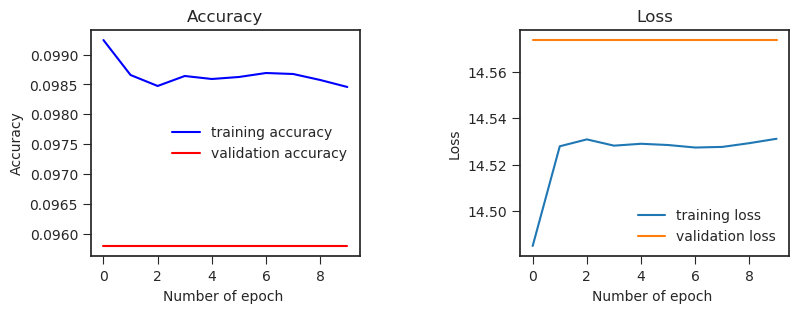

In [51]:
plot_acc_loss(history)

### Save the model using Keras

In [49]:
# with keras optimiser we can save the model+weight
if not os.path.exists(FLAGS.model_dir_keras):
    os.makedirs(FLAGS.model_dir_keras)
model_opt_keras.save(FLAGS.model_dir_keras+'keras_model.h5')

### Reload the model and make evaluation using Keras

In [84]:
reload_model_opt_keras=tf.keras.models.load_model(FLAGS.model_dir_keras+'keras_model.h5')

In [85]:
score = reload_model_opt_keras.evaluate(x_train, 
                                        y_train, 
                                        verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train loss: 0.06794429655395409
Train accuracy: 0.97975


### Monitoring using TensorBoard

### Evaluate the model using Keras and tf.data.dataset

In [90]:
score = model_opt_keras.evaluate(x_test, 
                       y_test, 
                       verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.14456331603423458
Test accuracy: 0.9623


In [91]:
score = model_opt_keras.evaluate(x_train, 
                       y_train, 
                       verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train loss: 0.09529252001663747
Train accuracy: 0.9703


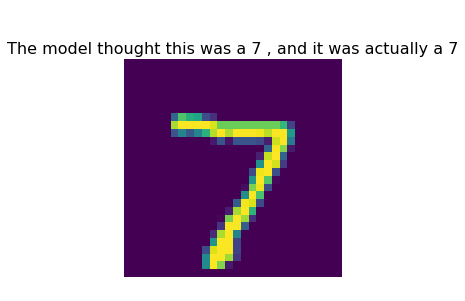

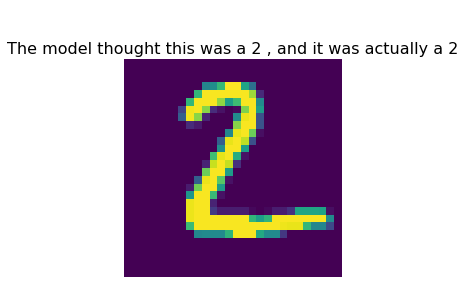

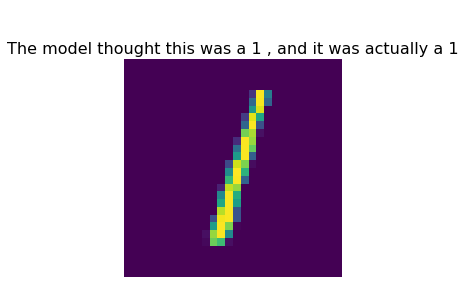

In [688]:
for i in range(0,3):
    show(x_test[i], 'The model thought this was a {} , and it was actually a {}'.format(np.argmax(predictions[i]['dense_3']),np.argmax(y_test[i])))